In [ ]:
# Needed for successful imports
%cd ../..

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from src.Dataset import CustomDataset
from src.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm
from src.TestHelpers import test_model, calculate_accuracy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

# set seed for pytorch
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

c:\Users\BLOOM\Documents\Github\DLProject
c:\Users\BLOOM\Documents\Github\DLProject
cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360

x_train = np.load(f'input/train_data_{dataset_ver}.npy')
x_val = np.load(f'input/val_data_{dataset_ver}.npy')
x_test = np.load(f'input/test_data_{dataset_ver}.npy')

y_train = np.load(f'input/train_labels_{dataset_ver}.npy')
y_val = np.load(f'input/val_labels_{dataset_ver}.npy')
y_test = np.load(f'input/test_labels_{dataset_ver}.npy')

In [3]:
print(x_train.shape)
print(x_val.shape)

(11578, 60, 9)
(1654, 60, 9)


(11578, 60, 9) (3308, 60, 9) (1654, 60, 9)


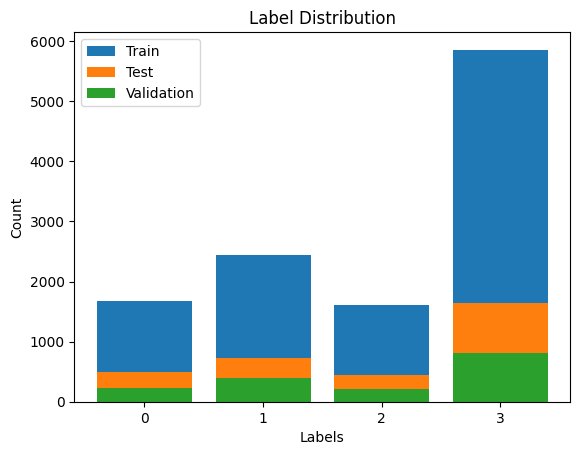

In [4]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [5]:
# %load_ext tensorboard
# %tensorboard --logdir tensorboard
# %reload_ext tensorboard
!taskkill /F /IM tensorboard.exe

ERROR: The process "tensorboard.exe" not found.


# Streamlined Train + Test Process

In [6]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

def streamline_train_and_test(Autoencoder, tag, early_stop, dropout_rate, num_epochs, lr_rate):
    ### Streamlined training of model + SVM ###
    encoder_ver = f'{n_hidden}h{num_epochs}e{dropout_rate}dr{lr_rate}lr'
    train_losses, val_losses = train_model(Autoencoder, train_dataloader, val_dataloader, val_dataset, n_input, n_hidden, dataset_ver, encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
    plot_loss_graph(train_losses, val_losses, tag)
    encoded_data, labels = encode_data(train_dataloader, dataset_ver, tag, encoder_ver)
    svm_classifier = train_svm(encoded_data, labels.ravel(), dataset_ver, tag, encoder_ver)
    ### Streamlined testing of model + SVM ###
    test_labels, test_predictions = test_model(test_dataloader, dataset_ver, tag, encoder_ver)
    calculate_accuracy(test_labels, test_predictions, tag)

# CNN + LSTM Models

In [16]:
# Unidirectional 1-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(input_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        nb_filters = 64
        self.hidden_size = hidden_size
        self.conv = nn.Conv1d(hidden_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size=hidden_size, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
    (output): Linear(in_features=360, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0285, Val Loss: 0.0407
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0207, Val Loss: 0.0366
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0240, Val Loss: 0.0229
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0209, Val Loss: 0.0169
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0167, Val Loss: 0.0134
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0121, Val Loss: 0.0115
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0077, Val Loss: 0.0109
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0112, Val Loss: 0.0110
ES_Counter: 1
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0133, Val Loss: 0.0105
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0094, Val Loss: 0.0095
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0094, Val Loss: 0.0091
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0117, Val Loss: 0.0089
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0088, Val Loss: 0.0090
ES_Counter: 1
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0072, Val Loss: 0.0081
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0072, Val Loss: 0.0079
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0076, Val Loss: 0.0080
ES_Counter: 1
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0055, Val Loss: 0.0077
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0067, Val Loss: 0.0073
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0065, Val Loss: 0.0075
ES_Counter: 1
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0102, Val Loss: 0.0069
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0086, Val Loss: 0.0071
ES_Counter: 1
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0066, Val Loss: 0.0070
ES_Counter: 2
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0074, Val Loss: 0.0069
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0045, Val Loss: 0.0064
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0068, Val Loss: 0.0066
ES_Counter: 1
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0062, Val Loss: 0.0062
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0051, Val Loss: 0.0063
ES_Counter: 1
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0050, Val Loss: 0.0061
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0045, Val Loss: 0.0060
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0050, Val Loss: 0.0061
ES_Counter: 1
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0053, Val Loss: 0.0059
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0060, Val Loss: 0.0058
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0050, Val Loss: 0.0058
ES_Counter: 1
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0058, Val Loss: 0.0058
ES_Counter: 2
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0067, Val Loss: 0.0056
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0062, Val Loss: 0.0054
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0074, Val Loss: 0.0055
ES_Counter: 1
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0063, Val Loss: 0.0055
ES_Counter: 2
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0053, Val Loss: 0.0054
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0053, Val Loss: 0.0056
ES_Counter: 1
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0057, Val Loss: 0.0053
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0047, Val Loss: 0.0068
ES_Counter: 1
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0045, Val Loss: 0.0056
ES_Counter: 2
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0030, Val Loss: 0.0052
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0042, Val Loss: 0.0052
ES_Counter: 1
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0039, Val Loss: 0.0055
ES_Counter: 2
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0067, Val Loss: 0.0051
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0047, Val Loss: 0.0054
ES_Counter: 1
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0066, Val Loss: 0.0052
ES_Counter: 2
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0045, Val Loss: 0.0049


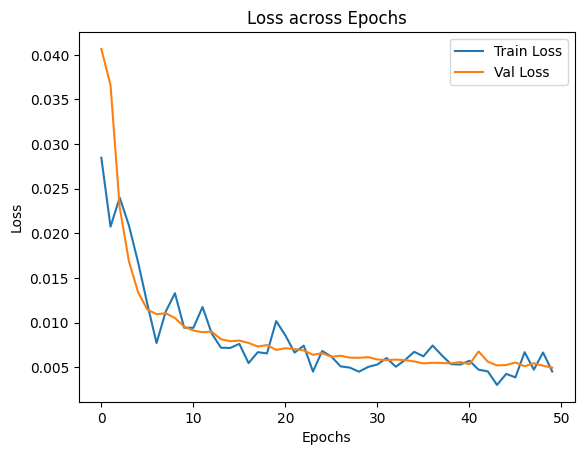

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9395509499136442


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 95.19%


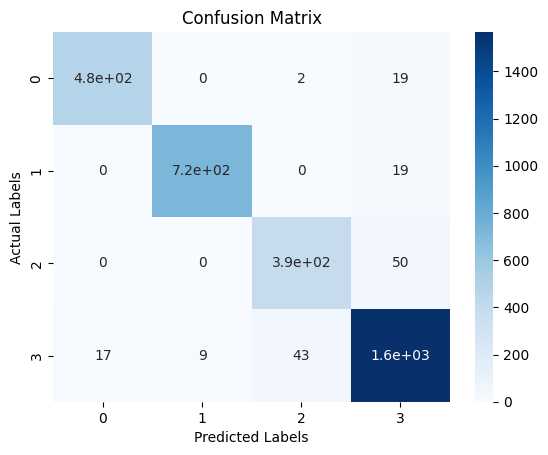

In [8]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_1_larm", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output): Linear(in_features=360, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0300, Val Loss: 0.0396
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0348, Val Loss: 0.0358
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0196, Val Loss: 0.0204
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0155, Val Loss: 0.0148
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0154, Val Loss: 0.0138
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0104, Val Loss: 0.0121
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0114, Val Loss: 0.0118
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0110, Val Loss: 0.0120
ES_Counter: 1
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0149, Val Loss: 0.0100
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0081, Val Loss: 0.0103
ES_Counter: 1
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0112, Val Loss: 0.0101
ES_Counter: 2
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0088, Val Loss: 0.0093
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0125, Val Loss: 0.0095
ES_Counter: 1
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0090, Val Loss: 0.0094
ES_Counter: 2
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0092, Val Loss: 0.0090
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0087, Val Loss: 0.0089
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0094, Val Loss: 0.0083
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0084, Val Loss: 0.0082
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0112, Val Loss: 0.0081
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0082, Val Loss: 0.0076
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0085, Val Loss: 0.0076
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0076, Val Loss: 0.0074
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0055, Val Loss: 0.0073
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0075, Val Loss: 0.0075
ES_Counter: 1
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0054, Val Loss: 0.0070
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0086, Val Loss: 0.0070
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0076, Val Loss: 0.0069
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0066, Val Loss: 0.0072
ES_Counter: 1
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0082, Val Loss: 0.0070
ES_Counter: 2
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0069, Val Loss: 0.0070
ES_Counter: 3
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0058, Val Loss: 0.0064
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0063, Val Loss: 0.0067
ES_Counter: 1
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0065, Val Loss: 0.0066
ES_Counter: 2
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0067, Val Loss: 0.0070
ES_Counter: 3
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0048, Val Loss: 0.0065
ES_Counter: 4
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0062, Val Loss: 0.0061
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0060, Val Loss: 0.0062
ES_Counter: 1
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0077, Val Loss: 0.0061
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0072, Val Loss: 0.0061
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0070, Val Loss: 0.0060
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0074, Val Loss: 0.0061
ES_Counter: 1
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0083, Val Loss: 0.0058
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0053, Val Loss: 0.0058
ES_Counter: 1
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0060, Val Loss: 0.0061
ES_Counter: 2
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0055, Val Loss: 0.0057
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0066, Val Loss: 0.0056
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0050, Val Loss: 0.0058
ES_Counter: 1
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0056, Val Loss: 0.0056
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0061, Val Loss: 0.0057
ES_Counter: 1
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0066, Val Loss: 0.0056
ES_Counter: 2


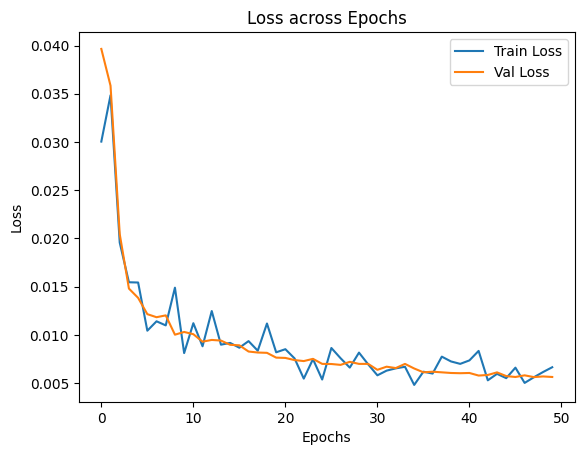

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9632987910189983


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 97.22%


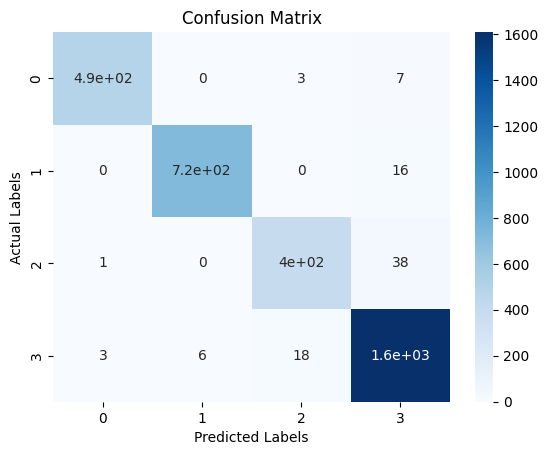

In [9]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_2_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (output): Linear(in_features=360, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0357, Val Loss: 0.0413
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0308, Val Loss: 0.0388
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0388, Val Loss: 0.0356
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0224, Val Loss: 0.0188
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0155, Val Loss: 0.0151
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0139, Val Loss: 0.0134
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0129, Val Loss: 0.0130
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0150, Val Loss: 0.0116
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0107, Val Loss: 0.0111
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0108, Val Loss: 0.0103
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0108, Val Loss: 0.0098
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0098, Val Loss: 0.0099
ES_Counter: 1
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0082, Val Loss: 0.0094
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0106, Val Loss: 0.0092
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0115, Val Loss: 0.0097
ES_Counter: 1
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0132, Val Loss: 0.0089
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0078, Val Loss: 0.0087
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0093, Val Loss: 0.0082
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0118, Val Loss: 0.0082
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0102, Val Loss: 0.0078
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0090, Val Loss: 0.0082
ES_Counter: 1
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0075, Val Loss: 0.0078
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0075, Val Loss: 0.0076
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0114, Val Loss: 0.0076
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0062, Val Loss: 0.0079
ES_Counter: 1
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0086, Val Loss: 0.0075
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0090, Val Loss: 0.0078
ES_Counter: 1
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0065, Val Loss: 0.0072
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0055, Val Loss: 0.0077
ES_Counter: 1
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0088, Val Loss: 0.0069
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0083, Val Loss: 0.0069
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0076, Val Loss: 0.0076
ES_Counter: 1
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0059, Val Loss: 0.0071
ES_Counter: 2
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0081, Val Loss: 0.0071
ES_Counter: 3
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0079, Val Loss: 0.0068
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0074, Val Loss: 0.0067
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0049, Val Loss: 0.0063
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0063, Val Loss: 0.0064
ES_Counter: 1
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0067, Val Loss: 0.0062
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0070, Val Loss: 0.0061
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0085, Val Loss: 0.0062
ES_Counter: 1
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0066, Val Loss: 0.0063
ES_Counter: 2
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0063, Val Loss: 0.0062
ES_Counter: 3
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0063, Val Loss: 0.0061
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0070, Val Loss: 0.0065
ES_Counter: 1
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0056, Val Loss: 0.0061
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0059, Val Loss: 0.0063
ES_Counter: 1
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0053, Val Loss: 0.0060
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0098, Val Loss: 0.0058
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0060, Val Loss: 0.0059
ES_Counter: 1


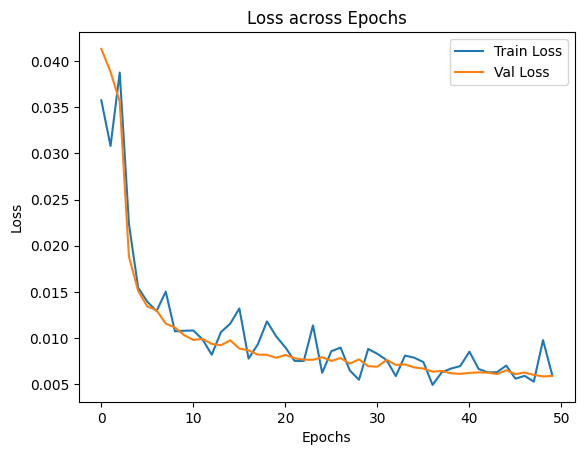

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9740932642487047


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 97.28%


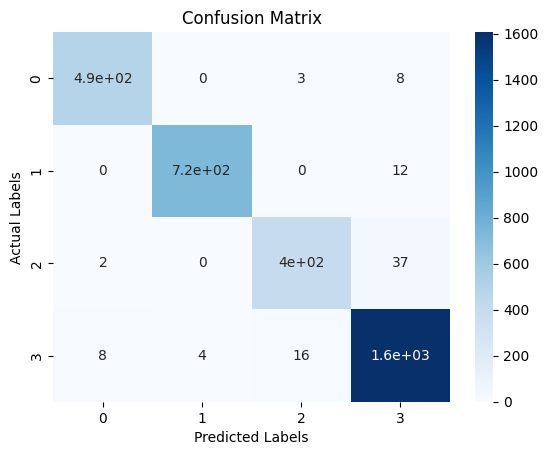

In [10]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_3_larm", early_stop=True, dropout_rate=0.2, num_epochs=50, lr_rate=1e-3)

In [15]:
# Unidirectional 2-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(input_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(input_size=nb_filters, hidden_size=hidden_size*2, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        return encoded_x[-1,:,:]


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(hidden_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=nb_filters, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size*2, batch_first=True)
        self.output = nn.Linear(self.hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 720, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(360, 720, batch_first=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0434, Val Loss: 0.0439
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0347, Val Loss: 0.0414
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0410, Val Loss: 0.0387
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0396, Val Loss: 0.0445
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0185, Val Loss: 0.0238
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0264, Val Loss: 0.0162
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0239, Val Loss: 0.0226
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0149, Val Loss: 0.0156
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0162, Val Loss: 0.0145
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0128, Val Loss: 0.0134
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0172, Val Loss: 0.0244
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0182, Val Loss: 0.0167
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0166, Val Loss: 0.0137
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0154, Val Loss: 0.0137
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0159, Val Loss: 0.0203
Early Stopping...


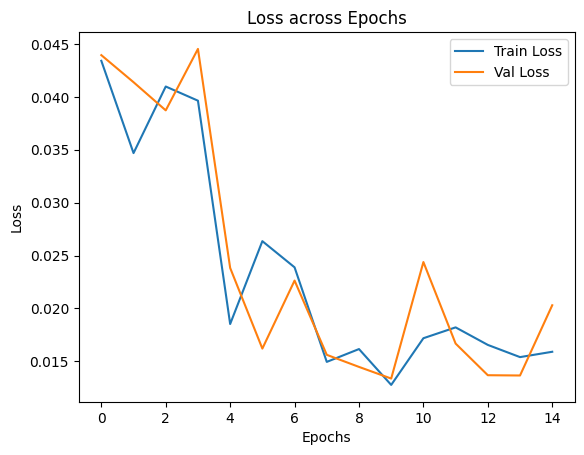

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.8881692573402418


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 90.39%


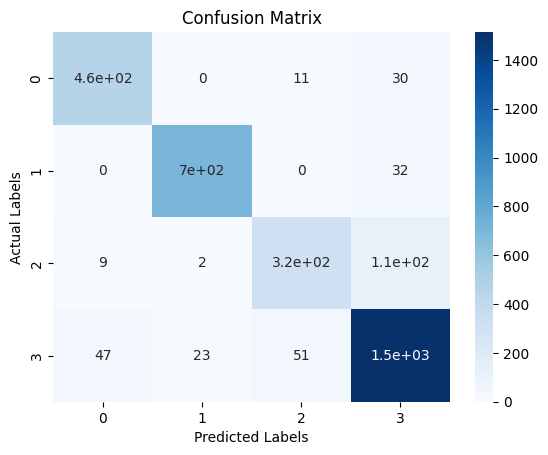

In [12]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_4_larm", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 720, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(360, 720, batch_first=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0435, Val Loss: 0.0446
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0396, Val Loss: 0.0410
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0385, Val Loss: 0.0394
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0192, Val Loss: 0.0192
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0137, Val Loss: 0.0153
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0140, Val Loss: 0.0139
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0202, Val Loss: 0.0130
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0137, Val Loss: 0.0120
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0077, Val Loss: 0.0112
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0091, Val Loss: 0.0104
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0060, Val Loss: 0.0101
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0107, Val Loss: 0.0108
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0106, Val Loss: 0.0094
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0064, Val Loss: 0.0087
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0106, Val Loss: 0.0090
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0076, Val Loss: 0.0085
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0082, Val Loss: 0.0080
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0045, Val Loss: 0.0081
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0090, Val Loss: 0.0074
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0046, Val Loss: 0.0076
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0058, Val Loss: 0.0078
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0059, Val Loss: 0.0072
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0059, Val Loss: 0.0073
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0044, Val Loss: 0.0071
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0062, Val Loss: 0.0067
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0058, Val Loss: 0.0067
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0060, Val Loss: 0.0066
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0074, Val Loss: 0.0067
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0065, Val Loss: 0.0064
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0059, Val Loss: 0.0064
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0050, Val Loss: 0.0061
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0053, Val Loss: 0.0067
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0043, Val Loss: 0.0058
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0049, Val Loss: 0.0057
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0044, Val Loss: 0.0059
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0059, Val Loss: 0.0058
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0039, Val Loss: 0.0057
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0037, Val Loss: 0.0064
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0052, Val Loss: 0.0056
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0055, Val Loss: 0.0056
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0035, Val Loss: 0.0056
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0042, Val Loss: 0.0055
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0047, Val Loss: 0.0053
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0038, Val Loss: 0.0057
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0042, Val Loss: 0.0053
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0050, Val Loss: 0.0056
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0039, Val Loss: 0.0053
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0035, Val Loss: 0.0053
Early Stopping...


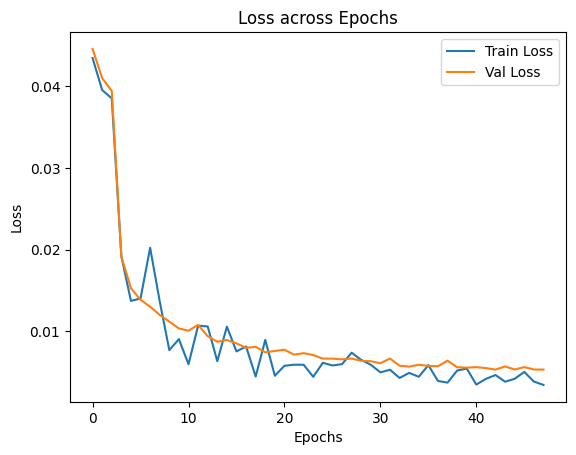

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9248704663212435


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 93.02%


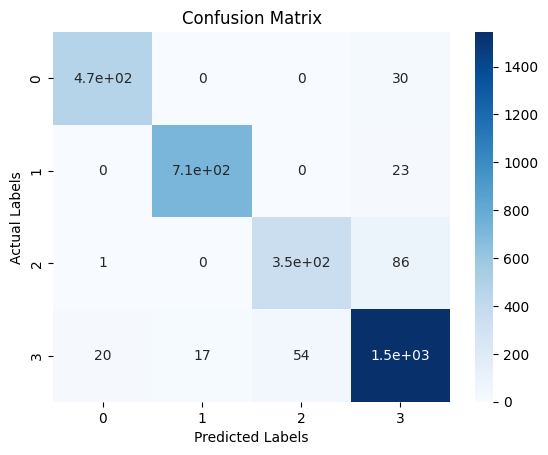

In [13]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_5_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 720, batch_first=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(360, 720, batch_first=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0575, Val Loss: 0.0444
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0444, Val Loss: 0.0421
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0325, Val Loss: 0.0394
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0291, Val Loss: 0.0250
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0169, Val Loss: 0.0186
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0172, Val Loss: 0.0152
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0137, Val Loss: 0.0136
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0136, Val Loss: 0.0130
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0114, Val Loss: 0.0119
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0180, Val Loss: 0.0114
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0110, Val Loss: 0.0107
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0112, Val Loss: 0.0108
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0078, Val Loss: 0.0102
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0117, Val Loss: 0.0100
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0089, Val Loss: 0.0102
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0086, Val Loss: 0.0095
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0111, Val Loss: 0.0095
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0062, Val Loss: 0.0091
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0108, Val Loss: 0.0089
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0074, Val Loss: 0.0095
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0119, Val Loss: 0.0086
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0083, Val Loss: 0.0084
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0074, Val Loss: 0.0084
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0086, Val Loss: 0.0084
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0082, Val Loss: 0.0085
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0074, Val Loss: 0.0090
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0073, Val Loss: 0.0078
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0073, Val Loss: 0.0079
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0058, Val Loss: 0.0077
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0090, Val Loss: 0.0074
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0096, Val Loss: 0.0072
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0049, Val Loss: 0.0073
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0090, Val Loss: 0.0070
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0085, Val Loss: 0.0075
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0048, Val Loss: 0.0069
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0053, Val Loss: 0.0068
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0065, Val Loss: 0.0074
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0065, Val Loss: 0.0068
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0040, Val Loss: 0.0065
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0055, Val Loss: 0.0068
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0087, Val Loss: 0.0068
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0072, Val Loss: 0.0070
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0037, Val Loss: 0.0063
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0051, Val Loss: 0.0064
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0042, Val Loss: 0.0065
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0064, Val Loss: 0.0070
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0044, Val Loss: 0.0064
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0049, Val Loss: 0.0066
Early Stopping...


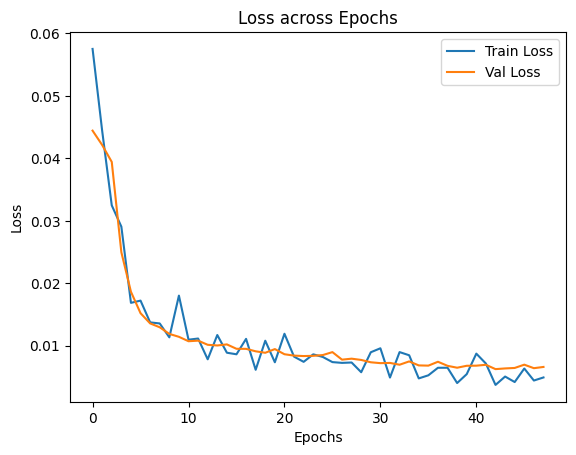

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.927461139896373


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 92.41%


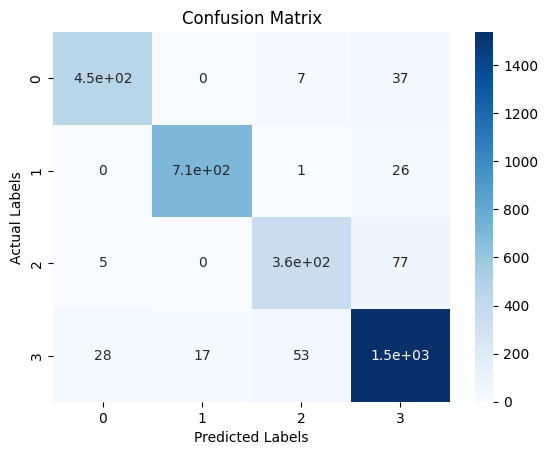

In [14]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_6_larm", early_stop=True, dropout_rate=0.2, num_epochs=50, lr_rate=1e-3)

In [15]:
# Bidirectional 1-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(input_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        nb_filters = 64
        self.hidden_size = hidden_size
        self.conv = nn.Conv1d(hidden_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0395, Val Loss: 0.0421
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0398, Val Loss: 0.0371
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0179, Val Loss: 0.0196
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0160, Val Loss: 0.0170
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0200, Val Loss: 0.0147
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0123, Val Loss: 0.0135
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0158, Val Loss: 0.0140
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0118, Val Loss: 0.0112
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0097, Val Loss: 0.0107
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0099, Val Loss: 0.0113
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0091, Val Loss: 0.0092
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0093, Val Loss: 0.0100
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0069, Val Loss: 0.0089
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0088, Val Loss: 0.0080
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0084, Val Loss: 0.0085
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0053, Val Loss: 0.0077
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0111, Val Loss: 0.0080
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0069, Val Loss: 0.0076
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0091, Val Loss: 0.0074
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0046, Val Loss: 0.0072
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0073, Val Loss: 0.0067
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0079, Val Loss: 0.0074
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0056, Val Loss: 0.0064
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0074, Val Loss: 0.0065
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0080, Val Loss: 0.0067
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0069, Val Loss: 0.0069
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0069, Val Loss: 0.0060
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0074, Val Loss: 0.0057
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0050, Val Loss: 0.0056
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0056, Val Loss: 0.0060
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0042, Val Loss: 0.0057
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0069, Val Loss: 0.0062
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0051, Val Loss: 0.0052
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0050, Val Loss: 0.0057
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0043, Val Loss: 0.0055
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0041, Val Loss: 0.0051
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0072, Val Loss: 0.0053
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0049, Val Loss: 0.0053
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0067, Val Loss: 0.0051
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0042, Val Loss: 0.0052
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0047, Val Loss: 0.0049
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0030, Val Loss: 0.0049
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0033, Val Loss: 0.0050
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0044, Val Loss: 0.0049
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0063, Val Loss: 0.0051
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0043, Val Loss: 0.0047
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0039, Val Loss: 0.0053
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0036, Val Loss: 0.0048
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0038, Val Loss: 0.0050
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0050, Val Loss: 0.0048


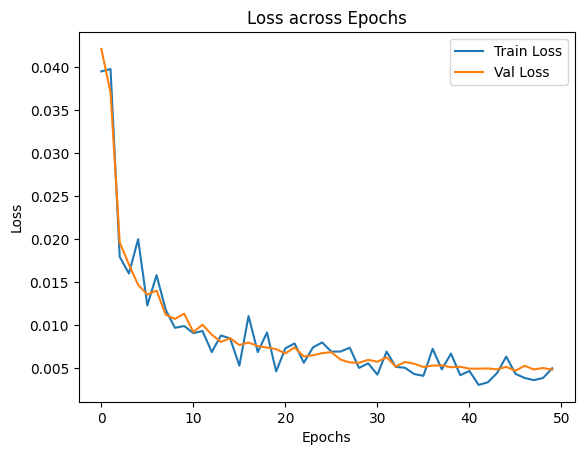

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9386873920552677


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 94.83%


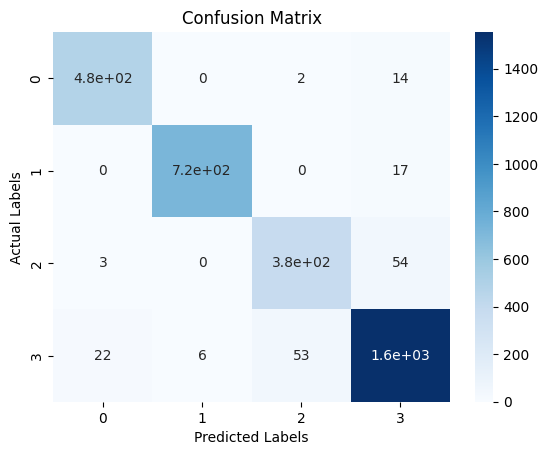

In [16]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_7_larm", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0455, Val Loss: 0.0438
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0414, Val Loss: 0.0386
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0223, Val Loss: 0.0205
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0150, Val Loss: 0.0164
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0241, Val Loss: 0.0152
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0156, Val Loss: 0.0139
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0172, Val Loss: 0.0141
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0133, Val Loss: 0.0123
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0114, Val Loss: 0.0121
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0114, Val Loss: 0.0126
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0073, Val Loss: 0.0110
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0110, Val Loss: 0.0114
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0116, Val Loss: 0.0110
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0081, Val Loss: 0.0089
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0111, Val Loss: 0.0084
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0093, Val Loss: 0.0085
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0108, Val Loss: 0.0088
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0100, Val Loss: 0.0088
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0094, Val Loss: 0.0079
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0073, Val Loss: 0.0078
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0063, Val Loss: 0.0076
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0082, Val Loss: 0.0076
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0072, Val Loss: 0.0072
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0090, Val Loss: 0.0074
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0072, Val Loss: 0.0073
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0056, Val Loss: 0.0071
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0069, Val Loss: 0.0068
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0048, Val Loss: 0.0069
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0076, Val Loss: 0.0066
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0080, Val Loss: 0.0064
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0055, Val Loss: 0.0063
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0085, Val Loss: 0.0064
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0066, Val Loss: 0.0065
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0061, Val Loss: 0.0061
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0077, Val Loss: 0.0065
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0079, Val Loss: 0.0059
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0065, Val Loss: 0.0062
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0079, Val Loss: 0.0060
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0065, Val Loss: 0.0059
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0078, Val Loss: 0.0057
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0081, Val Loss: 0.0057
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0063, Val Loss: 0.0057
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0065, Val Loss: 0.0055
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0070, Val Loss: 0.0056
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0057, Val Loss: 0.0059
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0076, Val Loss: 0.0054
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0048, Val Loss: 0.0059
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0067, Val Loss: 0.0056
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0050, Val Loss: 0.0055
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0058, Val Loss: 0.0052


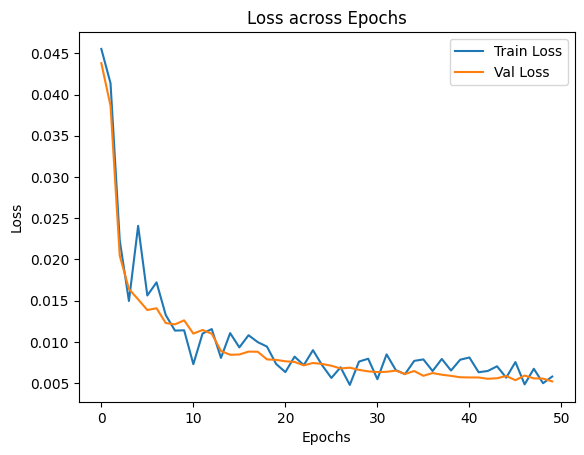

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9550949913644214


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.55%


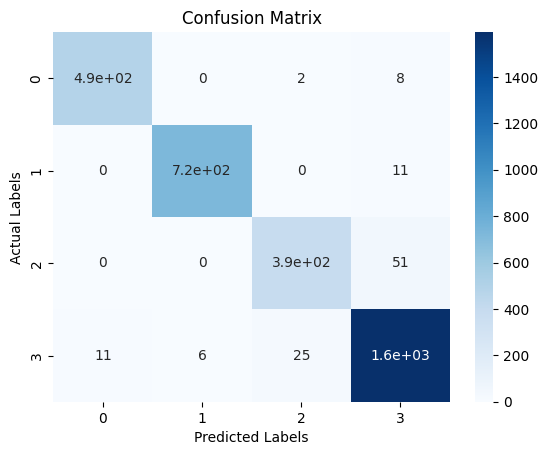

In [17]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_8_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0402, Val Loss: 0.0432
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0312, Val Loss: 0.0383
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0184, Val Loss: 0.0212
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0235, Val Loss: 0.0182
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0188, Val Loss: 0.0156
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0150, Val Loss: 0.0147
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0166, Val Loss: 0.0132
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0188, Val Loss: 0.0129
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0192, Val Loss: 0.0131
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0129, Val Loss: 0.0118
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0160, Val Loss: 0.0109
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0170, Val Loss: 0.0121
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0123, Val Loss: 0.0108
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0121, Val Loss: 0.0110
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0122, Val Loss: 0.0095
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0107, Val Loss: 0.0101
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0084, Val Loss: 0.0090
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0130, Val Loss: 0.0087
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0099, Val Loss: 0.0087
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0104, Val Loss: 0.0085
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0087, Val Loss: 0.0101
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0078, Val Loss: 0.0079
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0068, Val Loss: 0.0085
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0072, Val Loss: 0.0076
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0051, Val Loss: 0.0078
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0082, Val Loss: 0.0077
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0095, Val Loss: 0.0075
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0083, Val Loss: 0.0072
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0088, Val Loss: 0.0069
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0069, Val Loss: 0.0072
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0103, Val Loss: 0.0071
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0083, Val Loss: 0.0070
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0066, Val Loss: 0.0069
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0074, Val Loss: 0.0067
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0072, Val Loss: 0.0066
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0073, Val Loss: 0.0066
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0085, Val Loss: 0.0066
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0052, Val Loss: 0.0071
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0057, Val Loss: 0.0065
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0056, Val Loss: 0.0067
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0051, Val Loss: 0.0062
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0066, Val Loss: 0.0065
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0068, Val Loss: 0.0062
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0064, Val Loss: 0.0061
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0058, Val Loss: 0.0060
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0055, Val Loss: 0.0059
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0065, Val Loss: 0.0062
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0066, Val Loss: 0.0059
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0055, Val Loss: 0.0060
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0079, Val Loss: 0.0061


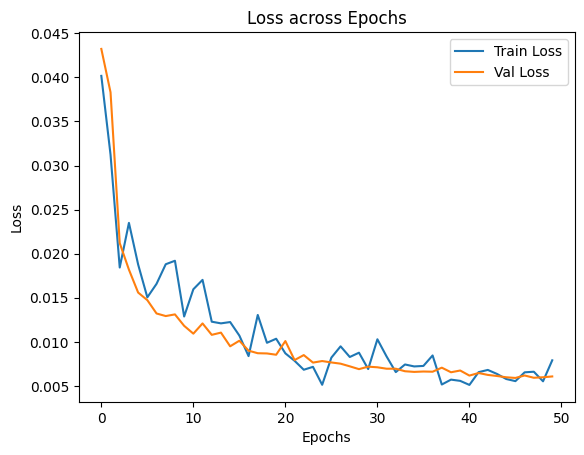

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9628670120898101


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.95%


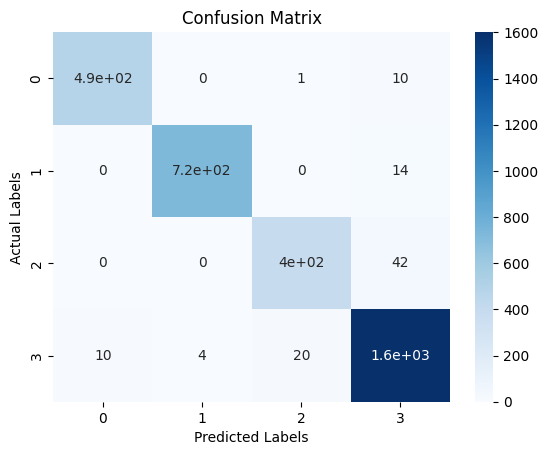

In [18]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_9_larm", early_stop=True, dropout_rate=0.2, num_epochs=50, lr_rate=1e-3)

In [19]:
# Bidirectional 2-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.2):
        super(Encoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(input_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(input_size=nb_filters, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        # Concatenate Forward + Backward Pass - (seq_len, batch, num_directions * hidden_size)  
        encoded_x = (encoded_x[0, :, :] + encoded_x[1, :, :])
        return encoded_x


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(hidden_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(input_size=nb_filters, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.output = nn.Linear(hidden_size*2, output_size)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0438, Val Loss: 0.0418
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0172, Val Loss: 0.0239
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0119, Val Loss: 0.0149
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0168, Val Loss: 0.0136
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0116, Val Loss: 0.0120
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0119, Val Loss: 0.0110
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0080, Val Loss: 0.0094
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0073, Val Loss: 0.0088
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0101, Val Loss: 0.0083
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0101, Val Loss: 0.0077
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0072, Val Loss: 0.0077
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0056, Val Loss: 0.0071
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0070, Val Loss: 0.0066
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0084, Val Loss: 0.0065
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0053, Val Loss: 0.0062
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0057, Val Loss: 0.0058
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0104, Val Loss: 0.0061
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0051, Val Loss: 0.0060
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0049, Val Loss: 0.0053
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0041, Val Loss: 0.0051
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0051, Val Loss: 0.0050
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0043, Val Loss: 0.0050
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0042, Val Loss: 0.0050
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0047, Val Loss: 0.0051
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0047, Val Loss: 0.0048
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0053, Val Loss: 0.0049
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0044, Val Loss: 0.0051
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0040, Val Loss: 0.0046
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0056, Val Loss: 0.0045
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0027, Val Loss: 0.0045
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0037, Val Loss: 0.0045
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0053, Val Loss: 0.0045
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0036, Val Loss: 0.0044
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0038, Val Loss: 0.0046
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0035, Val Loss: 0.0045
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0032, Val Loss: 0.0043
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0038, Val Loss: 0.0043
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0033, Val Loss: 0.0043
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0027, Val Loss: 0.0042
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0033, Val Loss: 0.0040
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0029, Val Loss: 0.0041
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0039, Val Loss: 0.0039
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0029, Val Loss: 0.0040
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0039, Val Loss: 0.0041
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0037, Val Loss: 0.0042
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0028, Val Loss: 0.0040
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0034, Val Loss: 0.0041
Early Stopping...


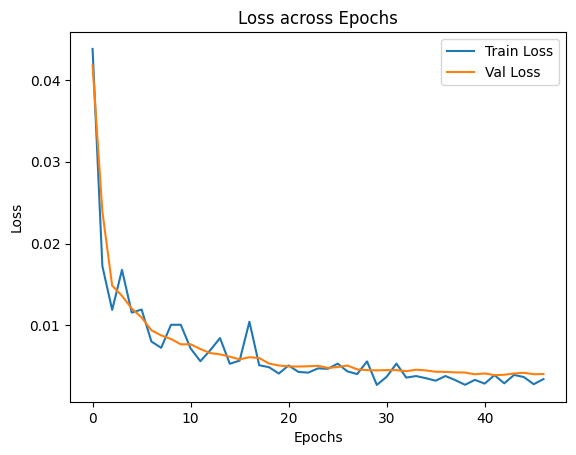

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9455958549222798


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 95.62%


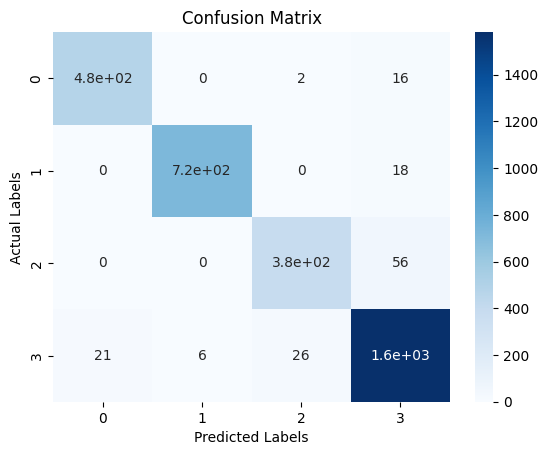

In [20]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_10_larm", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0341, Val Loss: 0.0417
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0190, Val Loss: 0.0183
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0168, Val Loss: 0.0153
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0128, Val Loss: 0.0123
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0111, Val Loss: 0.0109
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0160, Val Loss: 0.0098
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0090, Val Loss: 0.0090
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0110, Val Loss: 0.0082
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0097, Val Loss: 0.0077
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0063, Val Loss: 0.0073
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0051, Val Loss: 0.0071
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0081, Val Loss: 0.0069
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0036, Val Loss: 0.0067
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0074, Val Loss: 0.0063
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0049, Val Loss: 0.0066
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0070, Val Loss: 0.0067
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0048, Val Loss: 0.0060
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0066, Val Loss: 0.0057
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0063, Val Loss: 0.0059
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0048, Val Loss: 0.0059
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0038, Val Loss: 0.0053
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0043, Val Loss: 0.0053
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0045, Val Loss: 0.0053
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0043, Val Loss: 0.0051
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0060, Val Loss: 0.0050
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0035, Val Loss: 0.0052
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0041, Val Loss: 0.0053
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0027, Val Loss: 0.0047
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0042, Val Loss: 0.0048
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0048, Val Loss: 0.0048
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0045, Val Loss: 0.0047
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0074, Val Loss: 0.0046
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0026, Val Loss: 0.0045
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0045, Val Loss: 0.0050
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0048, Val Loss: 0.0045
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0030, Val Loss: 0.0044
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0054, Val Loss: 0.0045
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0032, Val Loss: 0.0043
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0035, Val Loss: 0.0043
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0041, Val Loss: 0.0046
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0031, Val Loss: 0.0042
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0034, Val Loss: 0.0042
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0029, Val Loss: 0.0041
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0032, Val Loss: 0.0043
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0034, Val Loss: 0.0042
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0042, Val Loss: 0.0043
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0025, Val Loss: 0.0042
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0033, Val Loss: 0.0039
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0044, Val Loss: 0.0040
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0036, Val Loss: 0.0040


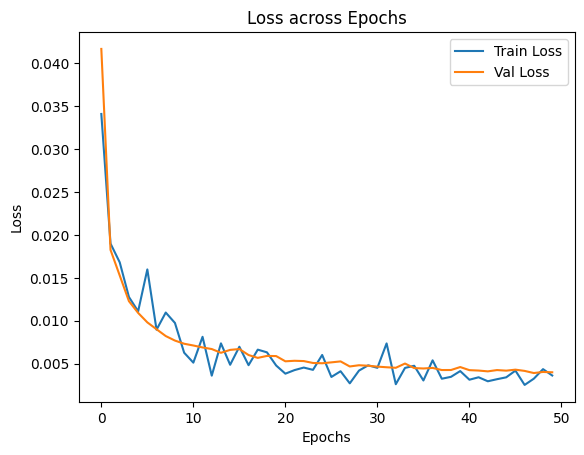

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9529360967184801


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 95.86%


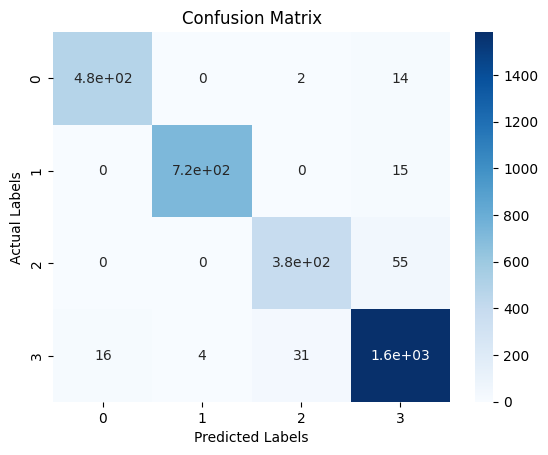

In [21]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_11_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (conv): Conv1d(360, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (LSTM1): LSTM(64, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0389, Val Loss: 0.0429
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0144, Val Loss: 0.0208
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0146, Val Loss: 0.0158
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0138, Val Loss: 0.0133
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0129, Val Loss: 0.0127
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0118, Val Loss: 0.0115
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0111, Val Loss: 0.0106
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0088, Val Loss: 0.0100
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0102, Val Loss: 0.0092
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0076, Val Loss: 0.0087
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0095, Val Loss: 0.0085
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0072, Val Loss: 0.0078
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0086, Val Loss: 0.0071
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0040, Val Loss: 0.0070
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0056, Val Loss: 0.0068
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0070, Val Loss: 0.0067
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0080, Val Loss: 0.0063
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0050, Val Loss: 0.0058
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0057, Val Loss: 0.0063
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0059, Val Loss: 0.0060
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0064, Val Loss: 0.0055
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0036, Val Loss: 0.0055
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0041, Val Loss: 0.0053
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0055, Val Loss: 0.0056
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0068, Val Loss: 0.0051
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0047, Val Loss: 0.0050
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0050, Val Loss: 0.0051
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0070, Val Loss: 0.0049
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0039, Val Loss: 0.0048
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0050, Val Loss: 0.0048
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0036, Val Loss: 0.0049
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0042, Val Loss: 0.0046
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0048, Val Loss: 0.0048
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0041, Val Loss: 0.0044
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0046, Val Loss: 0.0047
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0032, Val Loss: 0.0045
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0033, Val Loss: 0.0046
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0028, Val Loss: 0.0045
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0043, Val Loss: 0.0043
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0043, Val Loss: 0.0045
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0032, Val Loss: 0.0043
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0030, Val Loss: 0.0042
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0034, Val Loss: 0.0042
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0038, Val Loss: 0.0042
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0034, Val Loss: 0.0042
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0056, Val Loss: 0.0041
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0039, Val Loss: 0.0042
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0030, Val Loss: 0.0041
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0022, Val Loss: 0.0040
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0033, Val Loss: 0.0042


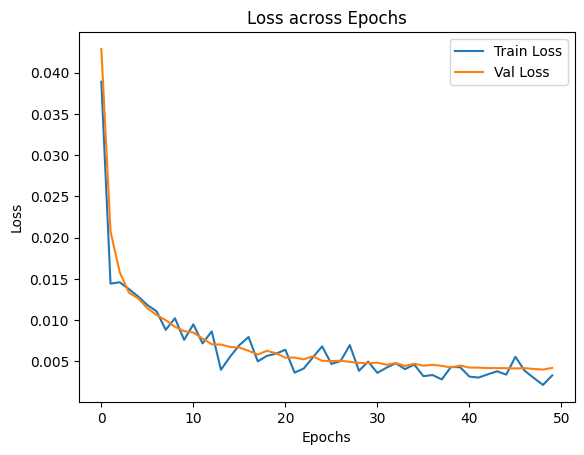

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9550949913644214


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 95.89%


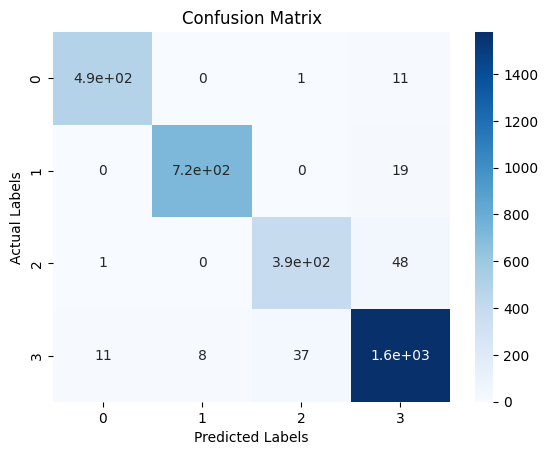

In [22]:
streamline_train_and_test(Autoencoder, tag="cnn_lstm_run_12_larm", early_stop=True, dropout_rate=0.2, num_epochs=50, lr_rate=1e-3)